# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

Импортируем все необходиые библиотеки, откроем данные, проверим дубликаты. Затем перейдем к обработке пропусков и выбросов.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, make_scorer

In [3]:
df = pd.read_csv('/datasets/autos.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [4]:
df.duplicated().sum() # удаляем 4 дубликата
df = df.drop_duplicates().reset_index(drop=True)

In [5]:
df.query('Price == 0')

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
40,2016-03-26 22:06:17,0,NaN,1990,NaN,0,corsa,150000,1,petrol,opel,NaN,2016-03-26 00:00:00,0,56412,2016-03-27 17:43:34
111,2016-03-19 18:40:12,0,NaN,2017,manual,0,golf,5000,12,petrol,volkswagen,NaN,2016-03-19 00:00:00,0,21698,2016-04-01 08:47:05
115,2016-03-20 18:53:27,0,small,1999,NaN,0,NaN,5000,0,petrol,volkswagen,NaN,2016-03-20 00:00:00,0,37520,2016-04-07 02:45:22
152,2016-03-11 18:55:53,0,bus,2004,manual,101,meriva,150000,10,lpg,opel,yes,2016-03-11 00:00:00,0,27432,2016-03-12 23:47:10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354201,2016-03-09 15:56:30,0,NaN,2000,manual,65,corsa,150000,0,NaN,opel,yes,2016-03-09 00:00:00,0,23758,2016-03-30 11:16:08
354234,2016-03-20 14:55:07,0,small,2002,manual,60,fiesta,150000,3,petrol,ford,NaN,2016-03-20 00:00:00,0,33659,2016-04-06 18:45:23
354244,2016-03-24 13:48:05,0,small,1999,manual,53,swift,150000,3,petrol,suzuki,NaN,2016-03-24 00:00:00,0,42329,2016-04-07 05:17:24
354273,2016-03-10 22:55:50,0,small,1999,manual,37,arosa,150000,7,petrol,seat,yes,2016-03-10 00:00:00,0,22559,2016-03-12 23:46:32


Поскольку Price это целевой признак, восстановить его по медиане или еще каким-то образом будет противоречить природе создания модели машинного обучения на этом же признаке. 10+ тысяч строк без указанной цены - меньше 3% датасета, удаляем.

In [6]:
df = df.query('Price > 0').reset_index(drop=True)

Сузим поле работы: избавимся от неинформативных признаков-столбцов.

In [7]:
%%time
df['DateCrawled'].value_counts()

CPU times: user 257 ms, sys: 105 µs, total: 257 ms
Wall time: 256 ms


2016-03-24 14:49:47    7
2016-03-19 21:49:56    6
2016-03-26 22:57:31    6
2016-03-05 14:44:30    5
2016-03-31 18:50:16    5
                      ..
2016-03-10 10:50:20    1
2016-03-19 20:36:19    1
2016-03-16 14:37:16    1
2016-04-04 16:52:57    1
2016-03-07 13:50:01    1
Name: DateCrawled, Length: 265135, dtype: int64

Выглядит бесполезно. Уберем также два других столбца с датами, месяцем регистрации (он избыточен, года регистрации достаточно), количество картинок, почтовый индекс (вряд ли в Европе так отличается цена продажи в зависимости от столицы/провинции, да и выяснить что где предстает проблематичным). 

In [8]:
df = df[['VehicleType', 
         'Gearbox', 
         'Power',
         'Kilometer',
         'FuelType',
         'Brand',
         'Model',
         'Repaired',
         'RegistrationYear',
         'Price']]

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 343593 entries, 0 to 343592
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   VehicleType       309843 non-null  object
 1   Gearbox           326238 non-null  object
 2   Power             343593 non-null  int64 
 3   Kilometer         343593 non-null  int64 
 4   FuelType          314134 non-null  object
 5   Brand             343593 non-null  object
 6   Model             326072 non-null  object
 7   Repaired          277727 non-null  object
 8   RegistrationYear  343593 non-null  int64 
 9   Price             343593 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 26.2+ MB


Приступаем к предобработке, обработке пропусков и т.д.

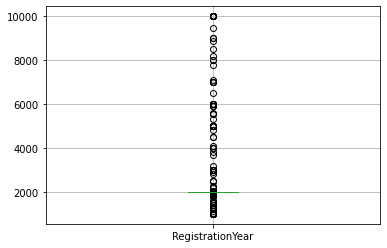

count    343593.00000
mean       2004.08983
std          78.41368
min        1000.00000
25%        1999.00000
50%        2003.00000
75%        2008.00000
max        9999.00000
Name: RegistrationYear, dtype: float64

In [10]:
df.boxplot('RegistrationYear')
plt.show()
df['RegistrationYear'].describe()

Видим огромное количество аномалий в годах регистрации автомобилей. Отрезаем всё будущее, чтобы удобнее было определить как лучше отрезать прошлое.

In [11]:
df.loc[df['RegistrationYear'] > 2016]
df = df.loc[df['RegistrationYear'] <= 2016]
df.loc[df['RegistrationYear'] == 2016]

,VehicleType,Gearbox,Power,Kilometer,FuelType,Brand,Model,Repaired,RegistrationYear,Price
15,NaN,NaN,60,150000,petrol,volkswagen,polo,NaN,2016,300
30,NaN,manual,60,150000,petrol,renault,clio,NaN,2016,899
34,NaN,manual,75,150000,petrol,volkswagen,golf,no,2016,350
36,NaN,NaN,0,150000,gasoline,renault,kangoo,no,2016,1500
50,NaN,manual,55,5000,NaN,hyundai,other,NaN,2016,1400
...,...,...,...,...,...,...,...,...,...,...
343339,NaN,manual,60,150000,petrol,volkswagen,golf,NaN,2016,395
343347,NaN,manual,60,150000,petrol,opel,astra,yes,2016,299
343399,NaN,manual,0,150000,gasoline,mitsubishi,colt,no,2016,3000
343427,NaN,manual,0,150000,NaN,mercedes_benz,clk,yes,2016,1350


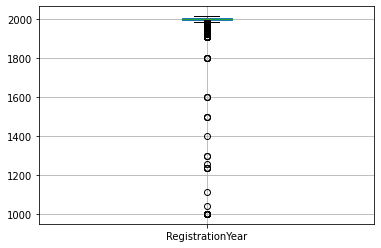

count    329814.000000
mean       2002.461727
std          12.963860
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        2016.000000
Name: RegistrationYear, dtype: float64

In [12]:
df.boxplot('RegistrationYear')
plt.show()
df['RegistrationYear'].describe()

Всё ещё много аномалий. Отрезать придется на глазок: выберем 1950 год, вряд ли в продаже есть реально существенное количество автомобилей, выпущенных ранее.

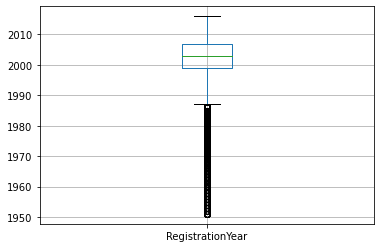

In [13]:
df = df.loc[df['RegistrationYear'] > 1950]
df.boxplot('RegistrationYear')
plt.show()

In [14]:
df['Model'].isna().sum()

15578

Признак Model является одним из основных для предсказания цены. Пропущено 5% данных в этом признаке. Нет возможности восстановить корректно эти данные, удалим пропуски.

In [15]:
df = df.loc[~df['Model'].isna()]

In [16]:
df['VehicleType'].value_counts()

sedan          86317
small          74894
wagon          61698
bus            27424
convertible    19028
coupe          14764
suv            11055
other           2640
Name: VehicleType, dtype: int64

Выглядит неплохо, но есть порядка 34000 пропусков. Возможно, получится их восстановить по марке/модели. 

In [17]:
df.query('VehicleType.isna()' or 'Model.notna()').head(20)

,VehicleType,Gearbox,Power,Kilometer,FuelType,Brand,Model,Repaired,RegistrationYear,Price
0,NaN,manual,0,150000,petrol,volkswagen,golf,NaN,1993,480
15,NaN,NaN,60,150000,petrol,volkswagen,polo,NaN,2016,300
30,NaN,manual,60,150000,petrol,renault,clio,NaN,2016,899
34,NaN,manual,75,150000,petrol,volkswagen,golf,no,2016,350
36,NaN,NaN,0,150000,gasoline,renault,kangoo,no,2016,1500
50,NaN,manual,55,5000,NaN,hyundai,other,NaN,2016,1400
69,NaN,manual,150,150000,NaN,bmw,5er,no,1997,2300
75,NaN,manual,90,150000,gasoline,volkswagen,golf,NaN,2000,800
77,NaN,manual,75,150000,petrol,opel,astra,yes,2016,150
90,NaN,NaN,60,150000,NaN,ford,ka,NaN,2000,250


In [18]:
df.query('Model == "golf"').head(20)

,VehicleType,Gearbox,Power,Kilometer,FuelType,Brand,Model,Repaired,RegistrationYear,Price
0,NaN,manual,0,150000,petrol,volkswagen,golf,NaN,1993,480
3,small,manual,75,150000,petrol,volkswagen,golf,no,2001,1500
8,small,manual,101,150000,NaN,volkswagen,golf,NaN,1998,999
31,sedan,NaN,0,150000,petrol,volkswagen,golf,no,1994,245
34,NaN,manual,75,150000,petrol,volkswagen,golf,no,2016,350
56,sedan,manual,101,150000,petrol,volkswagen,golf,no,1998,1000
72,sedan,manual,105,150000,gasoline,volkswagen,golf,no,2006,6600
75,NaN,manual,90,150000,gasoline,volkswagen,golf,NaN,2000,800
110,sedan,manual,265,150000,petrol,volkswagen,golf,no,2002,6300
120,sedan,manual,54,150000,petrol,volkswagen,golf,no,1990,1000


Странно: среди "гольфов" есть и седаны, и "маленькие" машины (хэтчбэки?..) и даже типы wagon & bus ! Вероятно, в данных есть ошибки, но реально ли избавиться от них всех? Самым простым решением представляется заполнить пропуски в данных признаках (отнесём сюда же Gearbox & FuelType) самым частым значением по той же модели. 

In [19]:
df['VehicleType'] = df['VehicleType'].fillna(df.groupby('Model')['VehicleType'].transform(lambda x: x.value_counts().idxmax()))

In [20]:
df['FuelType'] = df['FuelType'].fillna(df.groupby('Model')['FuelType'].transform(lambda x: x.value_counts().idxmax()))

In [21]:
df['Gearbox'] = df['Gearbox'].fillna(df.groupby('Model')['Gearbox'].transform(lambda x: x.value_counts().idxmax()))

In [22]:
df['Repaired'] = df['Repaired'].fillna('unknown')

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 314040 entries, 0 to 343592
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   VehicleType       314040 non-null  object
 1   Gearbox           314040 non-null  object
 2   Power             314040 non-null  int64 
 3   Kilometer         314040 non-null  int64 
 4   FuelType          314040 non-null  object
 5   Brand             314040 non-null  object
 6   Model             314040 non-null  object
 7   Repaired          314040 non-null  object
 8   RegistrationYear  314040 non-null  int64 
 9   Price             314040 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 26.4+ MB


Предобработка пропусков закончена. Осталось проверить другие аномалии.

In [24]:
df['Gearbox'].value_counts() # всё в норме

manual    252294
auto       61746
Name: Gearbox, dtype: int64

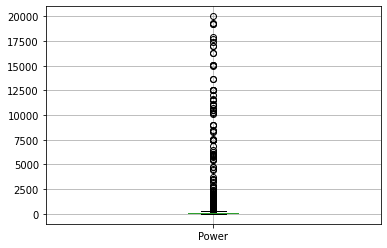

count    314040.000000
mean        112.857187
std         179.479775
min           0.000000
25%          75.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: Power, dtype: float64

In [25]:
df['Power'].unique()
df.boxplot('Power')
plt.show()
df['Power'].describe()

Видим очень много автомобилей с мощностью свыше 1000 л/с, что неправдоподобно. Заполним все такие значения медианными среди автомобилей той же модели.

In [26]:
df.loc[(df['Power'] > 600) | (df['Power'] <= 0), 'Power'] = None
df['Power'] = df['Power'].fillna(df.groupby('Model')['Power'].transform('median'))
df = df.loc[~df['Power'].isna()]
df['Power'] = df['Power'].astype('int64')

<AxesSubplot:xlabel='Power', ylabel='Count'>

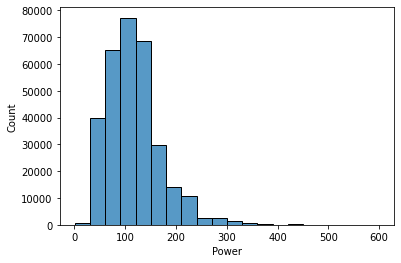

In [27]:
df['Power'].describe()
sns.histplot(df['Power'], bins=20)

,VehicleType,Gearbox,Power,Kilometer,FuelType,Brand,Model,Repaired,RegistrationYear,Price
27,bus,manual,50,5000,petrol,volkswagen,transporter,no,1981,1990
50,sedan,manual,55,5000,petrol,hyundai,other,unknown,2016,1400
151,suv,auto,194,5000,petrol,kia,sorento,unknown,2007,7500
152,sedan,manual,101,10000,petrol,volkswagen,golf,yes,1993,800
173,wagon,auto,110,10000,petrol,skoda,fabia,no,2015,16449
...,...,...,...,...,...,...,...,...,...,...
342910,sedan,manual,101,5000,petrol,audi,80,unknown,1990,550
343048,wagon,auto,150,5000,gasoline,audi,a6,yes,2002,2499
343105,coupe,manual,116,5000,petrol,ford,other,no,1973,15500
343312,small,manual,82,5000,petrol,peugeot,1_reihe,no,2015,10985


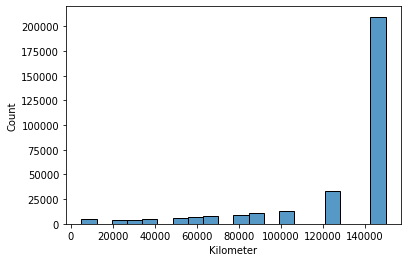

In [28]:
sns.histplot(df['Kilometer'], bins=20)
#df.boxplot('Kilometer')
#plt.show()

df.query('Kilometer < 20000')

Выглядит вполне естественно для подержанных машин, наверное выбросов нет. Есть, конечно, подозрительно малый пробег местами, но достоверность его установить или опровергнуть невозможно, с машинами бывает всякое.

In [29]:
df['Brand'].unique() 
df['Model'].unique() # опечаток и повторов нет, всё в норме

array(['golf', 'grand', 'fabia', '3er', '2_reihe', 'c_max', '3_reihe',
       'passat', 'navara', 'polo', 'twingo', 'a_klasse', 'scirocco',
       '5er', 'arosa', 'other', 'civic', 'transporter', 'punto',
       'e_klasse', 'clio', 'kadett', 'kangoo', 'one', 'fortwo', '1er',
       'b_klasse', 'signum', 'astra', 'a8', 'jetta', 'fiesta', 'c_klasse',
       'micra', 'vito', 'sprinter', '156', 'escort', 'forester',
       'xc_reihe', 'scenic', 'a4', 'ka', 'a1', 'insignia', 'combo',
       'focus', 'tt', 'corsa', 'a6', 'jazz', 'omega', 'slk', '7er', '80',
       '147', '100', 'z_reihe', 'sorento', 'v40', 'ibiza', 'mustang',
       'eos', 'touran', 'getz', 'a3', 'almera', 'megane', 'lupo', 'r19',
       'caddy', 'mondeo', 'cordoba', 'colt', 'impreza', 'vectra',
       'berlingo', 'tiguan', 'sharan', '6_reihe', 'c4', 'panda', 'up',
       'i_reihe', 'ceed', '5_reihe', 'yeti', 'octavia', 'zafira', 'mii',
       'rx_reihe', '6er', 'modus', 'fox', 'matiz', 'beetle', 'c1', 'rio',
       'touareg

In [30]:
df['Price'].describe(percentiles=[.05, .25, .5, .75])


count    314039.000000
mean       4671.516624
std        4558.489958
min           1.000000
5%          378.900000
25%        1250.000000
50%        2990.000000
75%        6790.000000
max       20000.000000
Name: Price, dtype: float64

Среди цен есть подозрительно низкие даже для новых машин. Обрезаем пять процентов.

In [31]:
df = df.query('Price > 390').reset_index(drop=True)
df['Price'].describe(percentiles=[.05, .25, .5, .75])

count    297945.000000
mean       4911.841417
std        4557.928860
min         393.000000
5%          600.000000
25%        1450.000000
50%        3200.000000
75%        6999.000000
max       20000.000000
Name: Price, dtype: float64

In [32]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 297945 entries, 0 to 297944
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   VehicleType       297945 non-null  object
 1   Gearbox           297945 non-null  object
 2   Power             297945 non-null  int64 
 3   Kilometer         297945 non-null  int64 
 4   FuelType          297945 non-null  object
 5   Brand             297945 non-null  object
 6   Model             297945 non-null  object
 7   Repaired          297945 non-null  object
 8   RegistrationYear  297945 non-null  int64 
 9   Price             297945 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 22.7+ MB


У нас все еще почти 300 тысяч строк в таблице, хоть нам и пришлось расстаться с 14,6% исходного датасета. Предобработка данных окончена. Переходим к их кодированию, подготовке для обучения в моделях.

In [33]:
#    Выделим признаки, целевой признак. Разделим выборку на обучающую и тестовую в соотношении 1:4.
dfc = df.copy()

X = dfc.drop('Price', axis=1)
y = dfc['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=76767)

In [34]:
# Так как в столбце model много значений, то преобразуем его методом ordinal, а остальные методом OHE

#Преобразуем столбец model
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)
encoder.fit(X_train[['Model']])
X_train['Model'] = encoder.transform(X_train[['Model']])
X_test['Model'] = encoder.transform(X_test[['Model']])

/tmp/ipykernel_48/2436030809.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['Model'] = encoder.transform(X_train[['Model']])
/tmp/ipykernel_48/2436030809.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['Model'] = encoder.transform(X_test[['Model']])


In [36]:
X_test.head()

,VehicleType,Gearbox,Power,Kilometer,FuelType,Brand,Model,Repaired,RegistrationYear
282320,small,manual,90,125000,petrol,opel,83.0,no,2008
199547,sedan,manual,179,150000,petrol,skoda,163.0,no,2001
240986,wagon,manual,115,5000,petrol,volkswagen,170.0,no,1994
98338,small,manual,80,80000,petrol,mazda,166.0,no,2005
103569,wagon,manual,109,150000,gasoline,ford,103.0,no,2010


In [37]:
%%time
enc = OneHotEncoder(handle_unknown='ignore')

ohe_cat = ['VehicleType', 'Gearbox', 'FuelType', 'Brand', 'Repaired']
num_col = ['Power', 'Kilometer', 'Model', 'RegistrationYear']

enc.fit(X_train[ohe_cat])
X_train_coded = pd.DataFrame(enc.transform(X_train[ohe_cat]).toarray(),
                             columns=enc.get_feature_names(ohe_cat),
                            index=X_train.index)

X_train = pd.concat((X_train[num_col], X_train_coded), axis=1)

X_test_coded = pd.DataFrame(enc.transform(X_test[ohe_cat]).toarray(),
                             columns=enc.get_feature_names(ohe_cat),
                            index=X_test.index)

X_test = pd.concat((X_test[num_col], X_test_coded), axis=1)


CPU times: user 720 ms, sys: 171 ms, total: 891 ms
Wall time: 892 ms


In [38]:
X_train.head(10)

,Power,Kilometer,Model,RegistrationYear,VehicleType_bus,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,...,Brand_smart,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,Repaired_no,Repaired_unknown,Repaired_yes
28475,92,150000,223.0,1990,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
70099,101,150000,233.0,2001,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
245365,143,100000,6.0,2008,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
50550,46,150000,83.0,1995,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
255448,125,150000,233.0,2004,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
263098,105,150000,116.0,2004,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
260735,80,90000,166.0,1998,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
295261,75,125000,173.0,2005,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
195150,65,100000,130.0,1968,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
212610,40,80000,83.0,1998,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [39]:
f"Размер обучающей выборки: {X_train.shape}"

'Размер обучающей выборки: (238356, 63)'

In [40]:
f"Размер тестовой  выборки: {X_test.shape}"

'Размер тестовой  выборки: (59589, 63)'

In [41]:
#Скалирование
scaler = StandardScaler()
scaler.fit(X_train)
columns = X_train.columns
X_train = pd.DataFrame(scaler.transform(X_train), columns = columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns = columns)

In [42]:
X_train.head()

,Power,Kilometer,Model,RegistrationYear,VehicleType_bus,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,...,Brand_smart,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,Repaired_no,Repaired_unknown,Repaired_yes
0,-0.558682,0.591380,1.619963,-2.002334,3.072833,-0.260674,-0.22478,-0.091313,-0.658941,-0.559783,...,-0.126822,-0.045757,-0.081974,-0.119394,-0.035202,1.898573,-0.098013,0.564314,-0.427918,-0.308227
1,-0.387259,0.591380,1.761081,-0.302277,-0.325433,-0.260674,-0.22478,-0.091313,-0.658941,-0.559783,...,-0.126822,-0.045757,-0.081974,-0.119394,-0.035202,-0.526711,-0.098013,-1.772064,-0.427918,3.244367
2,0.412716,-0.766761,-1.442307,0.779577,-0.325433,-0.260674,-0.22478,-0.091313,1.517586,-0.559783,...,-0.126822,-0.045757,-0.081974,-0.119394,-0.035202,-0.526711,-0.098013,0.564314,-0.427918,-0.308227
3,-1.434844,0.591380,-0.355695,-1.229581,-0.325433,-0.260674,-0.22478,-0.091313,-0.658941,1.786405,...,-0.126822,-0.045757,-0.081974,-0.119394,-0.035202,-0.526711,-0.098013,0.564314,-0.427918,-0.308227
4,0.069870,0.591380,1.761081,0.161374,-0.325433,-0.260674,-0.22478,-0.091313,-0.658941,-0.559783,...,-0.126822,-0.045757,-0.081974,-0.119394,-0.035202,-0.526711,-0.098013,0.564314,-0.427918,-0.308227


## Обучение моделей

### Линейная регрессия

In [43]:
def rmse(predict, actual):
    predict = np.array(predict)
    actual = np.array(actual)

    distance = predict - actual

    square_distance = distance ** 2

    mean_square_distance = square_distance.mean()

    score = np.sqrt(mean_square_distance)

    return score

rmse_score = make_scorer(rmse, greater_is_better = False)


In [44]:
%%time
lr = LinearRegression()
mse = cross_val_score(lr, X_train, y_train, cv=5, scoring='neg_mean_squared_error')


CPU times: user 9.93 s, sys: 4.71 s, total: 14.6 s
Wall time: 14.7 s


In [45]:
f"RMSE для линейной модели на валидационной выборке: {round((-mse.mean()) ** 0.5, 2)}"

'RMSE для линейной модели на валидационной выборке: 2781.57'

In [46]:
%%time
lr = LinearRegression()
lr.fit(X_train, y_train)

CPU times: user 2.37 s, sys: 1.1 s, total: 3.47 s
Wall time: 3.45 s


LinearRegression()

In [56]:
%%time
predictions_lr = lr.predict(X_test)

CPU times: user 36.1 ms, sys: 29.5 ms, total: 65.6 ms
Wall time: 13.1 ms


In [57]:
mse_lr = mean_squared_error(y_test, predictions_lr)
f"RMSE для линейной модели на тестовой выборке: {round((mse_lr) ** 0.5, 2)}"


'RMSE для линейной модели на тестовой выборке: 2749.19'

Теперь попробуем подобрать для линейной регрессии гиперпараметры с помощью GridSearchCV.

In [49]:
%%time
parameters = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}

grid = GridSearchCV(lr, parameters, cv=4, scoring = rmse_score, verbose=False)
grid.fit(X_train, y_train)
grid.best_params_

CPU times: user 56.5 s, sys: 21.3 s, total: 1min 17s
Wall time: 1min 17s


{'copy_X': True, 'fit_intercept': True, 'normalize': False}

In [50]:
%%time
lr_tuned = LinearRegression(**grid.best_params_).fit(X_train, y_train)


CPU times: user 2.11 s, sys: 554 ms, total: 2.67 s
Wall time: 2.63 s


In [58]:
%%time
lr_pred = lr_tuned.predict(X_test)

CPU times: user 14.6 ms, sys: 0 ns, total: 14.6 ms
Wall time: 5.66 ms


In [59]:
rmse_lr_tuned = mean_squared_error(y_test, lr_pred)
f"RMSE для tuned линейной модели на тестовой выборке: {round((rmse_lr_tuned) ** 0.5, 2)}"


'RMSE для tuned линейной модели на тестовой выборке: 2749.19'

После подбора гиперпараметров показания метрики практически не изменились и по-прежнему не дотягивают до бейзлайна (2750 против 2500).

### LightGBM

In [60]:
%%time
lgb_model = LGBMRegressor().fit(X_train, y_train)


CPU times: user 9.83 s, sys: 0 ns, total: 9.83 s
Wall time: 9.86 s


In [61]:
%%time
y_pred = lgb_model.predict(X_test)

CPU times: user 524 ms, sys: 0 ns, total: 524 ms
Wall time: 469 ms


In [62]:
%%time

rmse_lgbm = mean_squared_error(y_test, y_pred)
f"RMSE для LightGBM на тестовой выборке: {round((rmse_lgbm) ** 0.5, 2)}"

CPU times: user 2.7 ms, sys: 0 ns, total: 2.7 ms
Wall time: 1.73 ms


'RMSE для LightGBM на тестовой выборке: 1679.28'

Неплохой результат! Получится ли его улучшить с помощью подбора гиперпараметров?

In [63]:
%%time
lgbm_params = {"n_estimators": [15, 25],
               "max_depth": [8, 10]
              }

lgbm_cv_model = GridSearchCV(lgb_model,
                             lgbm_params,
                             cv=3,
                             scoring = 'neg_mean_squared_error',
                             n_jobs=-1,
                             verbose=True).fit(X_train, y_train)

lgbm_cv_model.best_params_


Fitting 3 folds for each of 4 candidates, totalling 12 fits
CPU times: user 1min 17s, sys: 1.7 s, total: 1min 19s
Wall time: 1min 19s


{'max_depth': 10, 'n_estimators': 25}

In [64]:
%%time
lgbm_tuned = LGBMRegressor(**lgbm_cv_model.best_params_).fit(X_train, y_train)

CPU times: user 3.92 s, sys: 92.4 ms, total: 4.01 s
Wall time: 4.02 s


In [65]:
%%time
lgbm_tuned_pred = lgbm_tuned.predict(X_test)

CPU times: user 144 ms, sys: 22.4 ms, total: 166 ms
Wall time: 109 ms


In [66]:
%%time

rmse_lgbm_tuned = mean_squared_error(y_test, lgbm_tuned_pred)
f"RMSE для LightGBM на тестовой выборке: {round((rmse_lgbm_tuned) ** 0.5, 2)}"

CPU times: user 2.13 ms, sys: 388 µs, total: 2.51 ms
Wall time: 1.46 ms


'RMSE для LightGBM на тестовой выборке: 1960.0'

## Анализ моделей

Необходимо проанализировать время обучения, время предсказания и качество моделей.

- Наша дефолтная линейная регрессия обучалась (Wall time): 2.69 s
- Готовила предсказания: 6.35 ms
- RMSE для линейной регрессии на тестовой выборке: 2749.19


- Подбор гиперпараметров для линейной регрессии длился: 1min 20s
- Обучение с подобранными гиперпараметрами: 2.85 s
- Готовила предсказания: 7.08 ms
- RMSE для оттюнингованной линейной регрессии на тестовой выборке: 2749.16 (показатель почти не изменился)


- LightGBM с дефолтными параметрами обучалась: 6.39 s
- Готовила предсказания: 406 ms
- RMSE для LightGBM на тестовой выборке: 1679.76


- Подбор гиперпараметров для LightGBM длился: 1 m 40s
- Обучение с подобранными гиперпараметрами: 16.8 s
- RMSE для LightGBM на тестовой выборке: 1960 (хуже, чем с базовыми гиперпараметрами).

Вывод: LightGBM неплохо работает "из коробки" :)) (или надо было дольше обучать и копаться с гиперпараметрами).

## Общий вывод
- мы провели анализ исходного датасета, обработали дубликаты, пропуски и выбросы
- провели кодирование и масштабирование признаков для ML
- протестировали по 2 модели линейной регрессии и градиентного бустинга (библиотека LightGBM): с дефолтными гиперпараметрами и с подобранными с помощью GridSearchCV
- сделали вывод о том, что лучший результат по RMSE достигается моделью, которая дольше всего обучалась (дефолтный LightGBM). 